<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/VAR_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroupTestA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using VAR Model based on Patient Visits Medical Laboratory Data (Group Test A)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

  Using cached https://files.pythonhosted.org/packages/7d/e8/43ffca541d2f208d516296950b25fe1084b35c2881f4d444c1346ca75815/scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0
Requirement already up-to-date: mxnet~=1.7 in /usr/local/lib/python3.7/dist-packages (1.8.0.post0)
Requirement already up-to-date: gluonts in /usr/local/lib/python3.7/dist-packages (0.7.6)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
  Using cached https://files.pythonhosted.org/packages/80/39/066ecde98f373430bf7a39a02d91c7075b01ef4fc928456e8e31577342d6/scipy-1.2.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: pmdarima 1.8.2 has requirement scipy>=1.3.2, but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requiremen

In [2]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [4]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


## **Step#2 Data Processing**

### **Picking Variable**

In [5]:
df = data.loc[:,['date', 'hm', 'hm_aw', 'hm_am', 'day_week']]
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df = df.set_index('date')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1348 entries, 2017-07-01 to 2021-03-09
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   hm        1348 non-null   int64
 1   hm_aw     1348 non-null   int64
 2   hm_am     1348 non-null   int64
 3   day_week  1348 non-null   int64
dtypes: int64(4)
memory usage: 52.7 KB


In [7]:
df.head(5)

,hm,hm_aw,hm_am,day_week
date,,,,
2017-07-01,66,48,63,6
2017-07-02,53,53,62,7
2017-07-03,74,54,59,1
2017-07-04,87,56,57,2
2017-07-05,95,62,58,3


### **Stationary Test**

Text(0, 0.5, 'Patient Visits Volume')

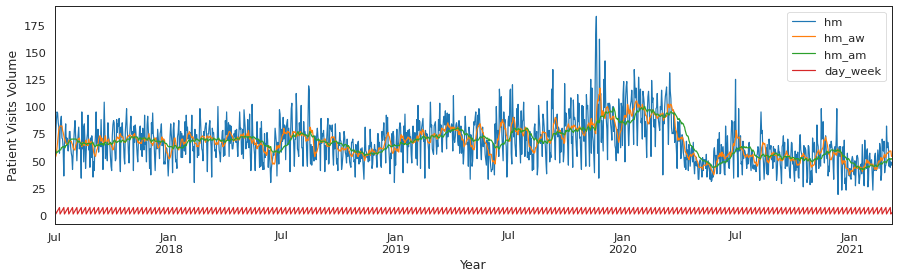

In [8]:
df.plot(figsize=(15,4))
plt.xlabel('Year')
plt.ylabel('Patient Visits Volume')

In [9]:
#creating test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):

  #Perform Dicky Fuller Test:
  print ('Result of Dicky-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                       index=['Test Statistic','p-value','#Lags Used',
                              'Number of Observations Used'])
  
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [10]:
#Loop to check all columns of the DF
import functools
df.apply(functools.partial(test_stationary))

Result of Dicky-Fuller Test:
Test Statistic                  -2.5335
p-value                          0.1075
#Lags Used                      20.0000
Number of Observations Used   1327.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.7086
p-value                          0.0726
#Lags Used                      23.0000
Number of Observations Used   1324.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.8019
p-value                          0.0580
#Lags Used                      23.0000
Number of Observations Used   1324.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:

hm          None
hm_aw       None
hm_am       None
day_week    None
dtype: object

### **Differencing**

In [11]:
df_diff = df.diff().dropna()
df_diff = df_diff.astype(int)
df_diff.head()

,hm,hm_aw,hm_am,day_week
date,,,,
2017-07-02,-13,5,-1,1
2017-07-03,21,1,-3,-6
2017-07-04,13,2,-2,1
2017-07-05,8,6,1,1
2017-07-06,-1,6,0,1


In [12]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1347 entries, 2017-07-02 to 2021-03-09
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   hm        1347 non-null   int64
 1   hm_aw     1347 non-null   int64
 2   hm_am     1347 non-null   int64
 3   day_week  1347 non-null   int64
dtypes: int64(4)
memory usage: 52.6 KB


### **Model Order Selection**

In [13]:
#Creating the VAR model
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(df_diff)

In [14]:
#Bestmodel order
modsel = model.select_order(15)
modsel.summary()

,AIC,BIC,FPE,HQIC
0,8.842,8.857,6918.,8.848
1,7.991,8.069,2953.,8.020
2,7.408,7.548,1648.,7.460
3,7.214,7.417,1359.,7.290
4,6.869,7.135,962.3,6.969
5,6.576,6.904,717.8,6.699
6,-59.02,-58.63,2.330e-26,-58.88
7,-63.07,-62.61,4.081e-28,-62.90
8,-61.73,-61.21,1.556e-27,-61.54
9,-64.66*,-64.08*,8.294e-29*,-64.44*


### **Splitting Data**

In [15]:
#creating the train and validation set
train = df_diff[:int(0.8*(len(df_diff)))]
test = df_diff[int(0.8*(len(df_diff))):]

In [16]:
train.shape

(1077, 4)

In [17]:
test.shape

(270, 4)

## **Step#3 Fitting and Training Model**

In [18]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(9)

## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

In [19]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(test))

In [20]:
prediction.shape

(270, 4)

In [21]:
pd.DataFrame(prediction).head()

,0,1,2,3
0,-7.4144,-3.9154,-0.0135,1.0000
1,-9.1125,0.9458,-0.5872,1.0000
2,25.1266,-0.6061,-0.3850,-6.0000
3,-0.8363,-0.8035,0.5053,1.0000
4,4.2292,-0.4695,0.8435,1.0000


In [22]:
df2 = pd.DataFrame(prediction)[1]
df2.head(10)

0   -3.9154
1    0.9458
2   -0.6061
3   -0.8035
4   -0.4695
5    2.0869
6   -0.8125
7    0.1645
8    0.2137
9   -0.1872
Name: 1, dtype: float64

In [23]:
df.head(1077)

,hm,hm_aw,hm_am,day_week
date,,,,
2017-07-01,66,48,63,6
2017-07-02,53,53,62,7
2017-07-03,74,54,59,1
2017-07-04,87,56,57,2
2017-07-05,95,62,58,3
...,...,...,...,...
2020-06-07,39,56,47,7
2020-06-08,65,54,48,1
2020-06-09,62,58,48,2


In [24]:
#Convert to original data, 63 from the last train data (hm) values
df_diff_pred = np.cumsum(df2) + 63
pred = pd.DataFrame(df_diff_pred.astype(int))
pred.head(10)

,1
0,59
1,60
2,59
3,58
4,58
5,60
6,59
7,59
8,59
9,59


In [25]:
#Take an original data
actual = np.cumsum(test.hm) + 63
actual = pd.DataFrame(actual)
actual.head(10)

,hm
date,
2020-06-13,50
2020-06-14,49
2020-06-15,94
2020-06-16,73
2020-06-17,61
2020-06-18,85
2020-06-19,65
2020-06-20,56
2020-06-21,55


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=actual['date'], y=actual['actual'], name="Actual"))
fig.add_trace(go.Scatter(x=pred['date'],y=pred['pred'],name="Predicted"))

fig.update_layout(
    title="Actual vs Predicted Patient Visits", 
    xaxis_title="date", yaxis_title="Patient", font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))

fig.update_layout(autosize=False,width=1000,height=400,)
fig.update_layout(legend_orientation="h")
fig.show()

In [27]:
# MSE and RMSE Score
print('MSE value :', mean_squared_error(actual, pred))
print('RMSE value  : ', sqrt(mean_squared_error(actual, pred)))

MSE value : 289.3259259259259
RMSE value  :  17.009583355447774
